In [1]:
from mave_calibration.initializations import constrained_gmm_init, gmm_init
from mave_calibration.skew_normal import density_utils
from mave_calibration.evidence_thresholds import get_tavtigian_constant

import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns
import numpy as np
from mave_calibration.em_opt.utils import get_sample_weights,constrained_em_iteration,em_iteration,get_likelihood
from mave_calibration.em_opt.constraints import density_constraint_violated
from tqdm.autonotebook import tqdm
import joblib
import json
import os
from pathlib import Path
from fire import Fire
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score

from main import standardize, load_data, singleFit, plot,bootstrap
from mave_calibration.initializations import constrained_gmm_init, get_gmm_responsibilities, fit_gmm

/tmp/ipykernel_4674/2904073023.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
X,S,sample_names = load_data(data_directory="/mnt/i/bio/mave_curation/",
                             dataset_id='Adamovich_BRCA1_Cisplatin',
                             standardize_to=None)

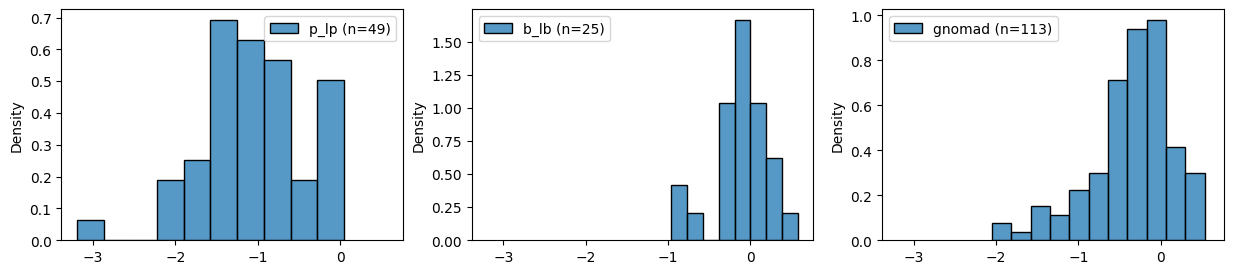

In [3]:
fig,ax = plt.subplots(1,len(sample_names),figsize=(5*len(sample_names),3),
                      sharex=True,sharey=False)
for i,sample_name in enumerate(sample_names):
    sns.histplot(X[S[:,i]],ax=ax[i],label=f"{sample_name} (n={S[:,i].sum()})",stat='density')
    
    ax[i].legend()

In [10]:
initial_params = constrained_gmm_init(X,)

In [11]:
initial_params

[[-0.4731445730523803, -0.5695182765594223, 0.498048862832349],
 [0.449763212458066, 0.0554178660834373, 0.3656904418779684]]

In [12]:
density_constraint_violated(*initial_params,(X.min()-X.std(),X.max()+X.std()))

False

In [ ]:
sns.histplot(X,stat='density')
rng = np.arange(X.min() - 2 * X.std(), X.max() + 2 * X.std(),.01)
for p in initial_params:
    plt.plot(rng,sp.skewnorm.pdf(rng,*p),label=f"Skew-Normal (μ={p[1]:.2f},σ={p[2]:.2f},α={p[0]:.2f})")
plt.legend()


In [ ]:
from joblib import Parallel, delayed

def do_fit(X, S, **kwargs):
    XB,SB,_ = bootstrap(X,S)
    return singleFit(XB, SB, **kwargs,buffer_stds=1)

results = Parallel(n_jobs=-1)(delayed(do_fit)(X, S) for i in range(25))
params, weights,likelihoods = sorted(results,key=lambda x: x[-1][-1])[-1]

In [ ]:
sns.histplot([r[-1][-1] for r in results])

In [ ]:
plot(X,S,sample_names,weights,params,figsize=(10,10))